In [1]:
from functools import partial
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import tqdm.auto as tqdm
from itertools import product, islice

from crn_lyapunov.crn import ReactionNetwork
from crn_lyapunov.smooth_lyapunov import SmoothLyapunov
from crn_lyapunov.training import Adversary, train_tight_sets
from crn_lyapunov.loss import (
    MaxDrift,
    TightLoss,
    ProbabilityLoss,
    CombinedLoss,
    PropertyLoss,
)
from crn_lyapunov.plot import (
    plot_drift_1d,
    plot_loss_traj,
    plot_level_set_comparison,
    plot_drift_2d,
    plot_hist_2d,
    plot_performances,
)
from crn_lyapunov.utils import performance_table, get_drift

In [2]:
sns.set_context("paper")
sns.set_style("white")

OUTPUT = Path("output")

# Birth-death

In [3]:
from crn_lyapunov.crn import BirthDeath

model_dir = OUTPUT / "birth_death"
net = BirthDeath(200, 1)


def quadratic_ref(x):
    return x**2


model, adv, history, history_dmax = train_tight_sets(
    net,
    quadratic_ref,
    TightLoss(k=1),
    n_adv_samples=16,
    n_rand_samples=16,
    max_n=700,
    lr=1e-3,
    hidden_dim=128,
    steps_evolve=1,
    n_epochs=500,
    non_negative=True,
    output_path=model_dir,
)

  0%|          | 0/500 [00:00<?, ?it/s]

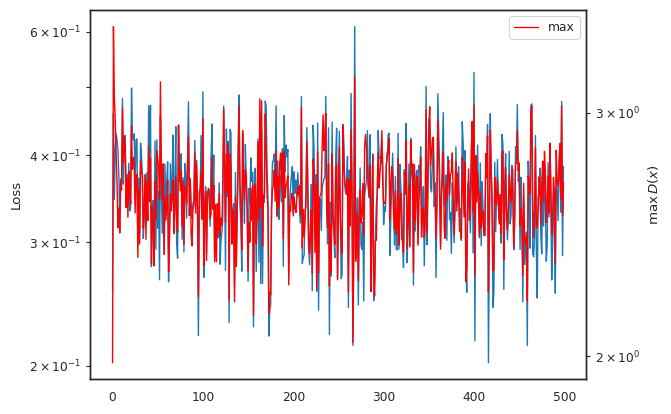

In [4]:
plot_loss_traj(history, history_dmax)
plt.show()

In [ ]:
sizes = performance_table(
    model, net, quadratic_ref, [10_000_000], max_drift_ref=20300, min_eps=-9
)

Pass 1/2: Finding D_max:   0%|          | 0/10000000 [00:00<?, ?it/s]

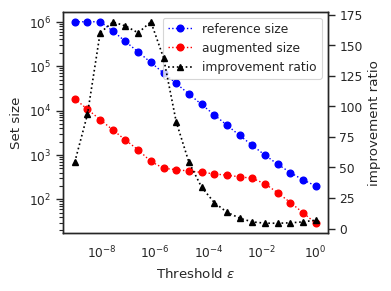

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_performances(sizes, ax=ax)
ax.set_xlabel("Threshold $\\epsilon$")
plt.tight_layout()
plt.savefig(model_dir / "setsizes.pdf")

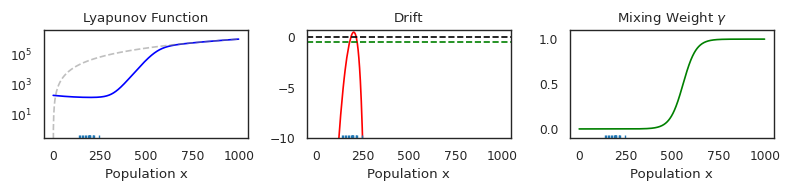

In [9]:
axes = plot_drift_1d(
    1000, model, quadratic_ref, net, adv_population=adv.population, figsize=(8, 2)
)
axes[0].set_yscale("log")
axes[1].set_ylim(-10, 0.7)
axes[2].set_ylabel("")
plt.tight_layout()
plt.savefig(model_dir / "overview.pdf")

In [10]:
# from scipy.stats import poisson
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# @torch.no_grad()
# def plot_level_set_comparison_with_optimum(model, network, reference_fn, mu, gamma, x_max=600, min_level=-4):
#     # 1. Setup State Space
#     x_range = torch.arange(start=0, end=x_max, step=max(1, x_max // 1000)).float().view(-1, 1)
#     x_np = x_range.numpy().flatten()

#     # 2. Compute Drifts & Ratios
#     # Augmented Model
#     drift_aug = get_drift(model, network, x_range).detach().numpy().flatten()
#     d_max_aug = np.max(drift_aug)
#     ratio_aug = drift_aug / d_max_aug

#     # Baseline Reference
#     class RefWrapper(torch.nn.Module):
#         def __init__(self, f):
#             super().__init__()
#             self.f = f
#         def forward(self, x):
#             return self.f(x)

#     drift_ref = get_drift(RefWrapper(reference_fn), network, x_range).detach().numpy().flatten()
#     d_max_ref = np.max(drift_ref)
#     ratio_ref = drift_ref / d_max_ref

#     # 3. Setup Mesh
#     eps_vals = np.logspace(min_level, 0, 300)
#     X, E = np.meshgrid(x_np, eps_vals)
#     thresholds = 1.0 - (1.0 / E)

#     # 4. Compute Sets
#     C_aug = ratio_aug[None, :] > thresholds
#     C_ref = ratio_ref[None, :] > thresholds

#     # 5. Compute Poisson Optimum (Ground Truth)
#     # The stationary distribution is Poisson(mu/gamma)
#     lam = mu / gamma
#     # For each eps, find the l_eps and h_eps such that mass is 1-eps
#     l_eps = poisson.ppf(eps_vals / 2, lam)
#     h_eps = poisson.ppf(1 - eps_vals / 2, lam)

#     # Create mask: True if x is within [l_eps, h_eps]
#     C_opt = (X >= l_eps[:, None]) & (X <= h_eps[:, None])

#     # 6. Plotting
#     fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

#     # Plot Reference (Blue) and Augmented (Red)
#     ax1.pcolormesh(X, E, C_ref, cmap="Blues", shading="auto", alpha=0.4, label="Linear Ref")
#     ax1.pcolormesh(X, E, C_aug, cmap="Reds", shading="auto", alpha=0.4, label="Augmented NN")

#     # Plot Optimum (Green Outline or subtle fill)
#     # We use a contour to show the boundary of the perfect set
#     ax1.contour(X, E, C_opt, levels=[0.5], colors='green', linestyles='dashed', linewidths=1.5)

#     # Styling
#     ax1.set_yscale("log")
#     ax1.set_ylabel(r"threshold $\epsilon$")
#     ax1.set_xlabel("State Space (x)")
#     ax1.set_title(f"Lyapunov Level Sets vs. Poisson Optimum ($\lambda={lam}$)")

#     # Custom Legend
#     from matplotlib.lines import Line2D
#     custom_lines = [Line2D([0], [0], color='blue', lw=4, alpha=0.4),
#                     Line2D([0], [0], color='red', lw=4, alpha=0.4),
#                     Line2D([0], [0], color='green', lw=2, linestyle='--')]
#     ax1.legend(custom_lines, ['Linear Reference Set', 'Augmented NN Set', r'Poisson Optimum (1-$\epsilon$ mass)'])

#     ax1.grid(True, which="both", ls="-", alpha=0.1)
#     plt.tight_layout()
#     plt.show()

# # Run with your parameters
# plot_level_set_comparison_with_optimum(
#     model, net, quadratic_ref,
#     mu=200.0, gamma=1.0,
#     min_level=-8, x_max=2000
# )

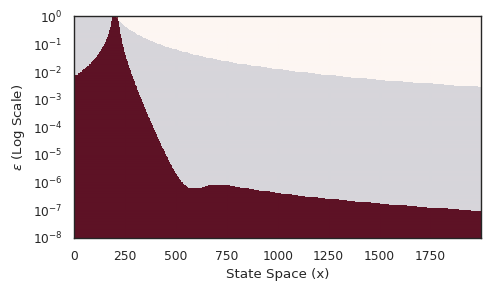

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_level_set_comparison(model, net, quadratic_ref, min_level=-8, x_max=2000, ax=ax)
plt.tight_layout()
plt.savefig(model_dir / "bd_levelsets.png", dpi=350)
# plt.savefig('bd_levelsets.pdf')

# Schloegl

In [12]:
def solve_schlogl_params(x_low, x_high, c2=0.001):
    x1 = x_low
    x3 = x_high
    x2 = (x1 + x3) / 2  # Midpoint for symmetry

    S = x1 + x2 + x3
    P = (x1 * x2) + (x2 * x3) + (x3 * x1)
    T = x1 * x2 * x3

    c1 = (c2 / 3) * S - c2
    c3 = (c2 / 6) * T
    c4 = (c2 / 6) * P - (c1 / 2) - (c2 / 3)

    return {"c1": c1, "c2": c2, "c3": c3, "c4": c4}


params = solve_schlogl_params(10, 100, c2=0.006)
print(params)

{'c1': 0.324, 'c2': 0.006, 'c3': 55.0, 'c4': 6.886}


Text(0.5, 1.0, 'Potential Wells (Minima = Modes)')

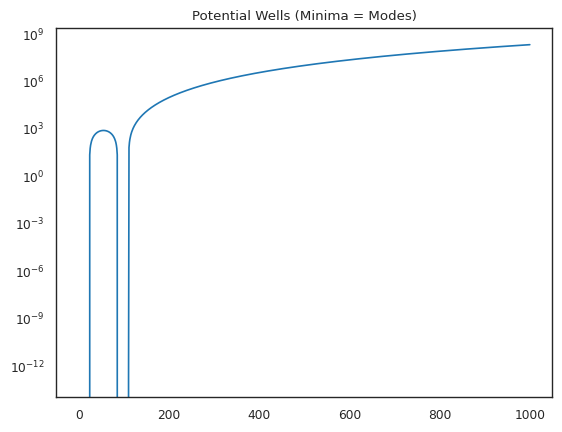

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def get_potential(x_range, c1, c2, c3, c4):
    # Drift f(x)
    def f(x):
        return (c3 + 0.5 * c1 * x * (x - 1)) - (
            c4 * x + (c2 / 6) * x * (x - 1) * (x - 2)
        )

    # Potential is -integral of f(x)
    # We can approximate it by cumulative sum
    drift_vals = [f(x) for x in x_range]
    potential = -np.cumsum(drift_vals)
    return potential


x = np.arange(0, 1000)
tune = 15
pot = get_potential(x, **params)
plt.plot(x, pot)
plt.yscale("log")
plt.title("Potential Wells (Minima = Modes)")

In [14]:
from crn_lyapunov.crn import Schloegl

model_dir = OUTPUT / "schloegl"
net = Schloegl(**params)

model, adv, history, history_dmax = train_tight_sets(
    net,
    quadratic_ref,
    TightLoss(),
    steps_evolve=5,
    n_adv_samples=8,
    n_rand_samples=8,
    max_n=500,
    lr=1e-3,
    hidden_dim=128,
    n_epochs=1000,
    non_negative=True,
    output_path=model_dir,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

(<Figure size 640x480 with 2 Axes>,
 <Axes: ylabel='Loss'>,
 <Axes: ylabel='$\\max\\, D(x)$'>)

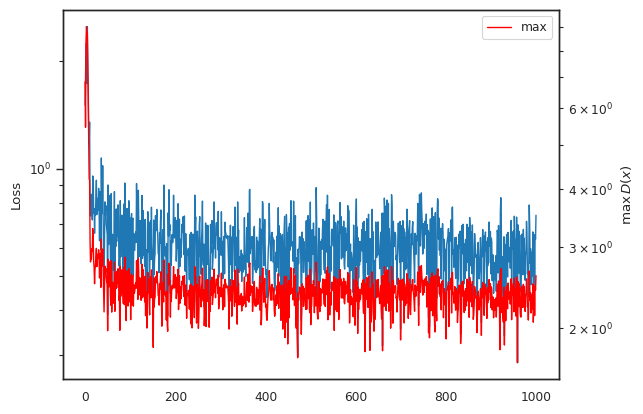

In [15]:
plot_loss_traj(history, history_dmax)

Pass 1/2: Finding D_max:   0%|          | 0/1000000 [00:00<?, ?it/s]

max D_aug=0.34752321243286133 max D_ref=8127.125


Pass 2/2: Counting States:   0%|          | 0/1000000 [00:00<?, ?it/s]

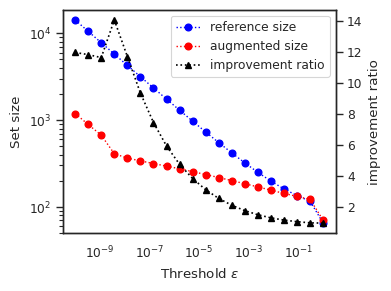

In [16]:
sizes = performance_table(model, net, quadratic_ref, [1_000_000], min_eps=-10)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_performances(sizes, ax=ax)
ax.set_xlabel("Threshold $\\epsilon$")
plt.tight_layout()
plt.savefig(model_dir / "setsizes.pdf")

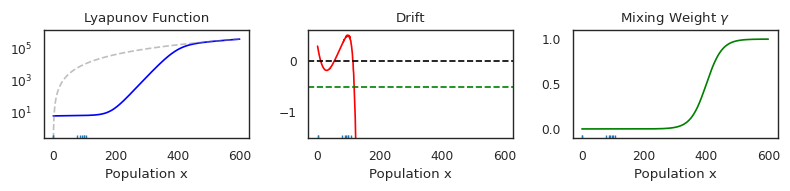

In [17]:
plot_drift_1d(
    600, model, quadratic_ref, net, adv_population=adv.population, figsize=(8, 2)
)
plt.tight_layout()
plt.savefig(model_dir / "overview.pdf", dpi=350)

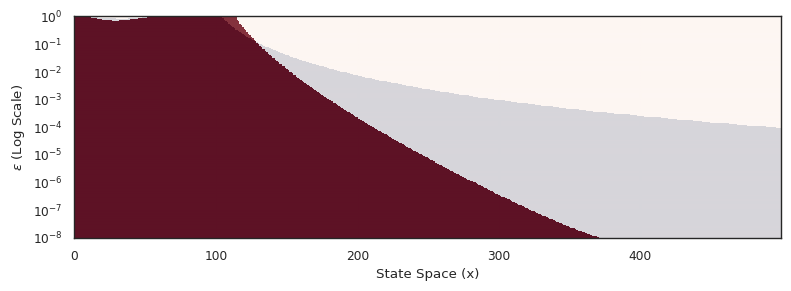

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
plot_level_set_comparison(model, net, quadratic_ref, min_level=-8, x_max=500, ax=ax)
plt.tight_layout()
plt.savefig(model_dir / "bd_levelsets.png", dpi=350)

# Parallel birth-death

In [19]:
from crn_lyapunov.crn import ParBD

model_dir = OUTPUT / "parbd"


def ref_g(x):
    X, Y = x[:, 0:1], x[:, 1:2]
    return (X - 0) ** 2 + (Y - 0) ** 2


net_parbd = ParBD()

## Property probability bound

In [20]:
n_min = 90
n_lim = 100


def indicator(xs):
    # print(xs.shape)
    return torch.logical_and(n_min <= xs[:, 0] < n_lim, n_min <= xs[:, 1] < n_lim)

In [21]:
from scipy.stats import poisson

In [22]:
d = poisson(100)
d.cdf(n_lim) ** 2 - d.cdf(n_min) ** 2 - 2 * (d.cdf(n_lim) - d.cdf(n_min)) * d.cdf(n_min)

np.float64(0.12615075759489427)

In [23]:
def sample(_max_n, n_rand_samples, n_species):
    x_range = torch.arange(n_min, n_lim).float()
    y_range = torch.arange(n_min, n_lim).float()

    x_mesh, y_mesh = torch.meshgrid(x_range, y_range, indexing="xy")

    return torch.stack([x_mesh.flatten(), y_mesh.flatten()], dim=1).float()

In [24]:
model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    TightLoss(k=100, n_adv=2**8, adv_weight=0),
    steps_evolve=5,
    hidden_dim=256,
    n_adv_samples=2**8,
    n_rand_samples=n_lim**2,
    max_n=300,
    n_epochs=10_000,
    lr=1e-3,
    sampler=sample,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Training interrupted by user.


(<Figure size 640x480 with 2 Axes>,
 <Axes: ylabel='Loss'>,
 <Axes: ylabel='$\\max\\, D(x)$'>)

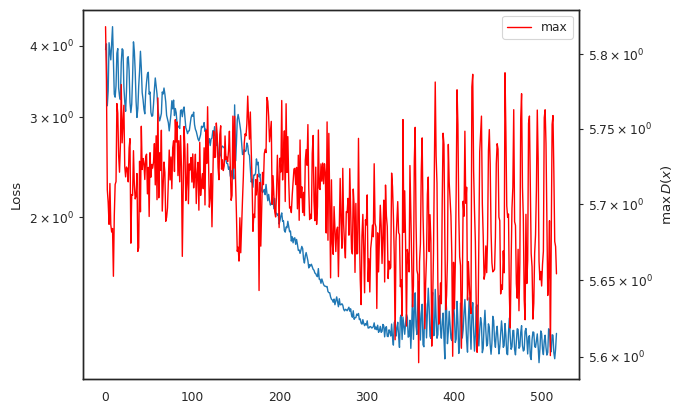

In [25]:
plot_loss_traj(h_loss, h_dmax)

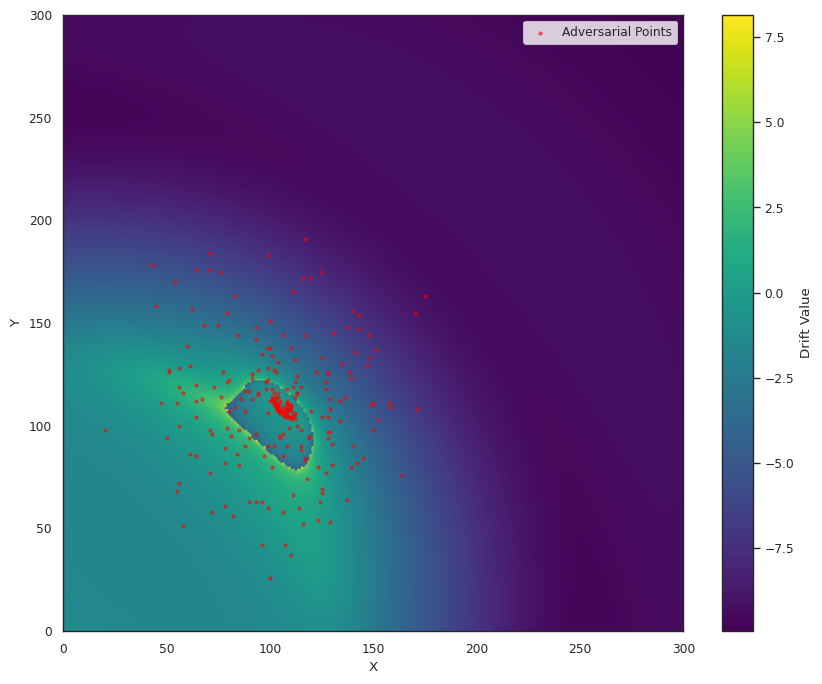

In [26]:
plot_drift_2d(model_parbd, net_parbd, 300, 300, log_drift=True, adversary=adv_parbd)

In [27]:
num_points = 200
x_range = torch.arange(0, num_points).float()
y_range = torch.arange(0, num_points).float()

x_mesh, y_mesh = torch.meshgrid(x_range, y_range, indexing="xy")

x_grid = torch.stack([x_mesh.flatten(), y_mesh.flatten()], dim=1).float()

with torch.no_grad():
    grid_drift = get_drift(model_parbd, net_parbd, x_grid).numpy()

drift_heatmap_data = grid_drift / grid_drift.max()

In [28]:
for eps in np.logspace(-3, 0, 10):
    inset = drift_heatmap_data * eps > eps - 1
    idcs = torch.logical_and(
        torch.logical_and(
            torch.logical_and(n_min <= x_grid[:, 0], x_grid[:, 0] < n_lim),
            n_min <= x_grid[:, 1],
        ),
        x_grid[:, 1] < n_lim,
    )
    print(f"{eps:.4f}  {inset[idcs].sum()}")

0.0010  100
0.0022  100
0.0046  100
0.0100  100
0.0215  100
0.0464  100
0.1000  100
0.2154  100
0.4642  100
1.0000  76


## Influence of $k$

In [29]:
model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    TightLoss(k=0.1),
    steps_evolve=5,
    hidden_dim=128,
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=300,
    n_epochs=10_000,
    lr=1e-3,
    output_path=model_dir / "0.1",
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
plot_loss_traj(h_loss, h_dmax)
sizes_p1 = performance_table(
    model_parbd,
    net_parbd,
    ref_g,
    [10_000, 10_000],
    max_drift_ref=103.0,
    max_drift_aug=0,
    chunk_size=1_000_000,
    min_eps=-3,
)
plot_performances(sizes_p1)

max D_aug=0 max D_ref=103.0


Pass 2/2: Counting States:   0%|          | 0/100000000 [00:00<?, ?it/s]

Larger max D_aug=50.36186218261719 - Restarting...
max D_aug=50.36186218261719 max D_ref=103.0


Pass 2/2: Counting States:   0%|          | 0/100000000 [00:00<?, ?it/s]

Larger max D_aug=53.34031677246094 - Restarting...
max D_aug=53.34031677246094 max D_ref=103.0


Pass 2/2: Counting States:   0%|          | 0/100000000 [00:00<?, ?it/s]


KeyboardInterrupt


KeyboardInterrupt



Error in callback <function flush_figures at 0x7f6985d0b880> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [ ]:
model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    TightLoss(k=1),
    steps_evolve=5,
    hidden_dim=128,
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=300,
    n_epochs=10_000,
    lr=1e-3,
    output_path=model_dir / "1",
)

In [ ]:
plot_loss_traj(h_loss, h_dmax)
sizes_1 = performance_table(
    model_parbd,
    net_parbd,
    ref_g,
    [10_000, 10_000],
    max_drift_ref=103.0,
    max_drift_aug=0,
    chunk_size=1_000_000,
    min_eps=-3,
)
plot_performances(sizes_1)

In [ ]:
plot_drift_2d(model_parbd, net_parbd, 300, 300, log_drift=True, adversary=adv_parbd)

In [ ]:
plot_hist_2d(
    model_parbd, net_parbd, 400, 400, 4e2, min_eps=-8, num_points=300, log_prob=True
)

In [ ]:
model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    TightLoss(k=10),
    steps_evolve=5,
    hidden_dim=128,
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=300,
    n_epochs=10_000,
    lr=1e-3,
    output_path=model_dir / "10",
)

In [ ]:
plot_loss_traj(h_loss, h_dmax)
sizes_10 = performance_table(
    model_parbd,
    net_parbd,
    ref_g,
    [10_000, 10_000],
    max_drift_ref=103.0,
    max_drift_aug=0,
    chunk_size=1_000_000,
    min_eps=-3,
)
plot_performances(sizes_10)

In [ ]:
model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    TightLoss(k=100),
    steps_evolve=5,
    hidden_dim=128,
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=300,
    n_epochs=10_000,
    lr=1e-3,
    output_path=model_dir / "100",
)

In [ ]:
plot_loss_traj(h_loss, h_dmax)
sizes_100 = performance_table(
    model_parbd,
    net_parbd,
    ref_g,
    [10_000, 10_000],
    max_drift_ref=103.0,
    max_drift_aug=0,
    chunk_size=1_000_000,
    min_eps=-3,
)
plot_performances(sizes_100)

In [ ]:
sizes_p1.to_csv(model_dir / "sizes_p1.csv")
sizes_1.to_csv(model_dir / "sizes_1.csv")
sizes_10.to_csv(model_dir / "sizes_10.csv")
sizes_100.to_csv(model_dir / "sizes_100.csv")

# sizes_p1 = pd.read_csv('sizes_p1.csv')
# sizes_1 = pd.read_csv('sizes_1.csv')
# sizes_10 = pd.read_csv('sizes_10.csv')
# sizes_100 = pd.read_csv('sizes_100.csv')

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(
    sizes_p1["epsilon"],
    sizes_p1["size_ref"] / sizes_p1["size_aug"],
    "1r:",
    lw=1,
    label=r"k=0.1",
)
plt.plot(
    sizes_1["epsilon"],
    sizes_1["size_ref"] / sizes_1["size_aug"],
    "+k:",
    lw=1,
    label=r"k=1",
)
plt.plot(
    sizes_10["epsilon"],
    sizes_10["size_ref"] / sizes_10["size_aug"],
    "xb:",
    lw=1,
    label=r"k=10",
)
plt.plot(
    sizes_100["epsilon"],
    sizes_100["size_ref"] / sizes_100["size_aug"],
    "2g:",
    lw=1,
    label=r"k=100",
)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("improvement ratio")
plt.xlabel(r"threshold $\epsilon$")
plt.legend()
plt.tight_layout()
plt.savefig(model_dir / "parbd_improvement.pdf")

# Competition

In [72]:
from crn_lyapunov.crn import Competition

model_dir = OUTPUT / "competition"


def ref_g(x):
    X, Y = x[:, 0:1], x[:, 1:2]
    return (X - 0) ** 2 + (Y - 0) ** 2


net_comp = Competition(k3=0.00004)

model_comp, adv_comp, h_loss, h_dmax = train_tight_sets(
    net_comp,
    ref_g,
    TightLoss(k=2),
    steps_evolve=2,
    hidden_dim=512,
    n_adv_samples=2**10,
    n_rand_samples=2**13,
    max_n=1500,
    n_epochs=5000,
    lr=1e-3,
    model_path=model_dir,
)

  0%|          | 0/5000 [00:00<?, ?it/s]

Training interrupted by user.


(<Figure size 640x480 with 2 Axes>,
 <Axes: ylabel='Loss'>,
 <Axes: ylabel='$\\max D(x)$'>)

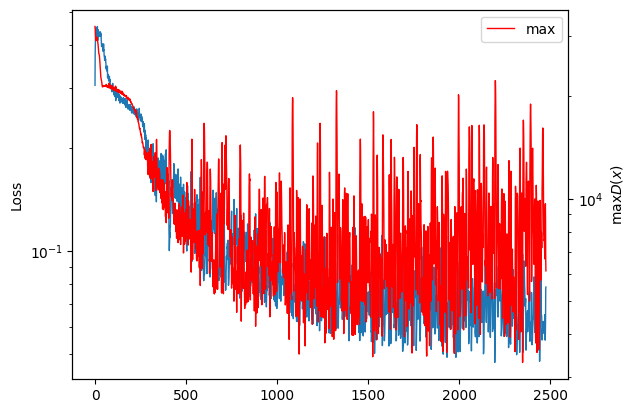

In [73]:
plot_loss_traj(h_loss, h_dmax)

/tmp/ipykernel_211805/4114275967.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


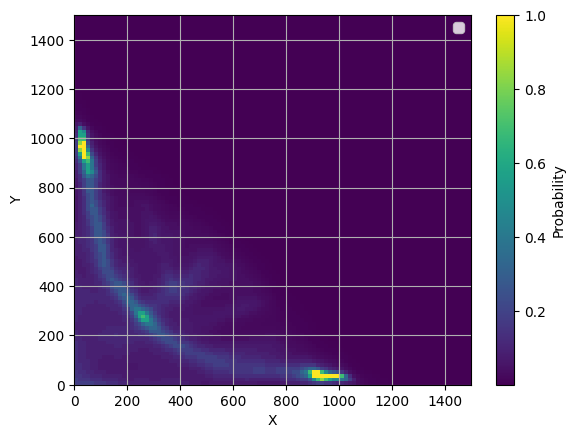

In [75]:
plot_hist_2d(
    model_comp, net_comp, 1500, 1500, 4e2, min_eps=-8, num_points=100, log_prob=False
)

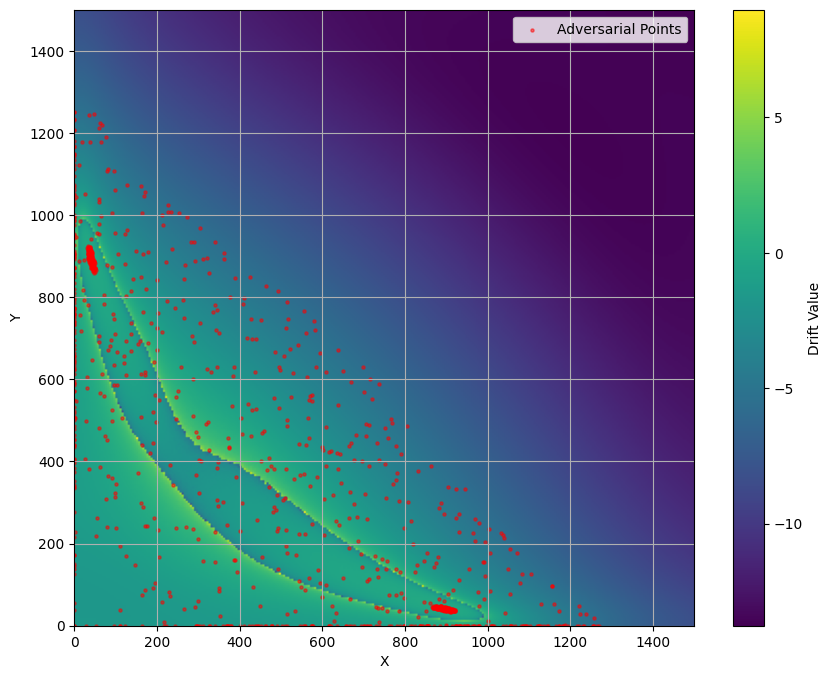

In [25]:
plot_drift_2d(model_comp, net_comp, 1500, 1500, log_drift=True, adversary=adv_comp)

# Toggle switch

In [32]:
from crn_lyapunov.crn import Toggle


def ref_g(x):
    X, Y = x[:, 0:1], x[:, 1:2]
    return (X - 0) ** 2 + (Y - 0) ** 2


net_toggle = Toggle(alpha=50, beta=0.1, k=10)

model_toggle, adv_toggle, h_loss, h_dmax = train_tight_sets(
    net_toggle,
    ref_g,
    TightLoss(k=1),
    steps_evolve=5,
    hidden_dim=2048,
    n_adv_samples=2**10,
    n_rand_samples=2**10,
    max_n=1000,
    n_epochs=1000,
    lr=1e-3,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training interrupted by user.


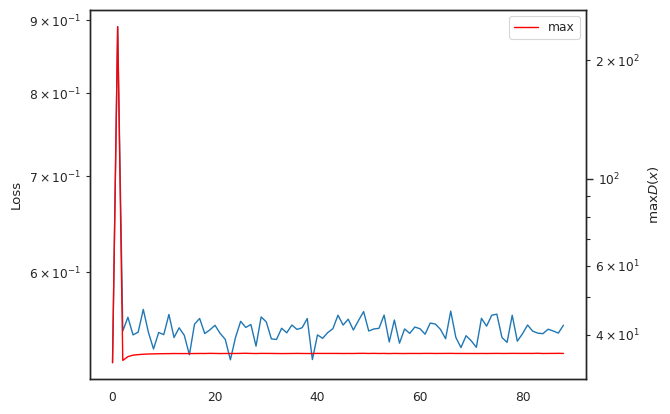

Pass 1/2: Finding D_max:   0%|          | 0/1000000 [00:00<?, ?it/s]


KeyboardInterrupt



In [34]:
plot_loss_traj(h_loss, h_dmax)
plt.show()
sizes = performance_table(
    model_toggle, net_toggle, ref_g, [1_000, 1_000], min_eps=-3, chunk_size=10_000
)
plot_performances(sizes)

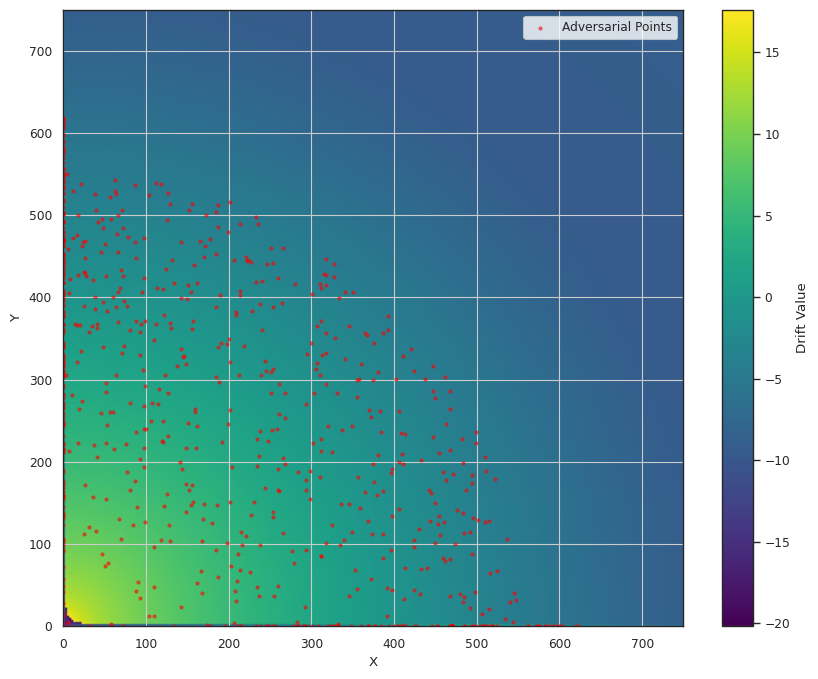

In [36]:
plot_drift_2d(model_toggle, net_toggle, 750, 750, log_drift=True, adversary=adv_toggle)

# p53

In [52]:
class P53Oscillator(ReactionNetwork):
    def __init__(self):
        # Species Order: [p53, pMdm2, Mdm2]
        # 0 -> p53           [1, 0, 0]
        # p53 -> 0           [-1, 0, 0]
        # p53 -> p53+pMdm2   [0, 1, 0]
        # p53 -> 0 (alpha4)  [-1, 0, 0]
        # pMdm2 -> Mdm2      [0, -1, 1]
        # Mdm2 -> 0          [0, 0, -1]
        S = torch.tensor(
            [
                [1.0, 0.0, 0.0],
                [-1.0, 0.0, 0.0],
                [0.0, 1.0, 0.0],
                [-1.0, 0.0, 0.0],
                [0.0, -1.0, 1.0],
                [0.0, 0.0, -1.0],
            ]
        )
        super().__init__(S, self._propensities)

        # Parameters
        self.k1, self.k2, self.k3 = 90.0, 0.002, 1.7
        self.k4, self.k5, self.k6 = 1.1, 0.93, 0.96
        self.k7 = 0.01

    def _propensities(self, x):
        p53, pMdm2, Mdm2 = x[:, 0:1], x[:, 1:2], x[:, 2:3]

        return torch.cat(
            [
                torch.full_like(p53, self.k1),  # k1
                self.k2 * p53,  # k2
                self.k4 * p53,  # k4
                self.k3 * Mdm2 * (p53 / (p53 + self.k7)),
                self.k5 * pMdm2,  # k5
                self.k6 * Mdm2,  # k6
            ],
            dim=1,
        )


def p53_reference_g(x):
    # g(x) = 120*p53 + 0.2*pMdm2 + 0.1*Mdm2
    weights = torch.tensor([120.0, 0.2, 0.1], device=x.device)
    return torch.sum(weights * x, dim=1, keepdim=True)

In [53]:
net_p53 = P53Oscillator()

model_p53, adv_p53, history_loss, history_max = train_tight_sets(
    net_p53,
    p53_reference_g,
    TightLoss(k=1),
    # CombinedLoss(dmax_weight=0.1, gamma=0.0),
    # MaxDrift(),
    steps_evolve=10,
    hidden_dim=1024,
    n_adv_samples=2**12,
    n_rand_samples=2**12,
    max_n=1000,
    n_epochs=5000,
    lr=1e-3,
)

  0%|          | 0/5000 [00:00<?, ?it/s]

Training interrupted by user.


In [ ]:
plot_loss_traj(history_loss, history_max)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

with torch.no_grad():
    drift = get_drift(model_p53, net_p53, adv_p53.population).numpy()

points = adv_p53.population.detach().numpy()

# Plot the point cloud and keep the mappable
sc = ax.scatter(
    points[:, 0], points[:, 1], points[:, 2], c=drift.flatten() > 0, cmap="viridis", s=5
)
dmax = drift.max()

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Drift")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

n = 100000
points = eval_xs = torch.rand(n, 3) * torch.tensor([2000, 2000, 2000])
with torch.no_grad():
    drift = get_drift(model_p53, net_p53, points).numpy()

eps = 1e-1
in_set = drift.flatten() / dmax * eps > eps - 1

drift = drift[in_set]
points = points[in_set]

# Plot the point cloud and keep the mappable
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=drift, cmap="viridis", s=1)

plt.show()

In [36]:
d = pd.DataFrame({"a": [0, 1, 2, 3], "b": [1, 2, 3, 4]})

In [37]:
print(", ".join(d.columns))

a, b


In [30]:
pd.__version__

'2.3.3'